<a href="https://colab.research.google.com/github/EdH66/CMAP-Analysis/blob/main/CMAP_Query_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connectivity Map and MPO Ranking

* CMAP_Predictions_Aggregatedlists.csv generated from DGE inputs to CMAP
* df_6k_curated_withMPO.csv taken from running MPO_automatic_calculator.ipynb
* Generates moa_relative_frequencies.csv for MEAN frequency of MOA occuring
* Generates list of priority compounds with NCS and MPO values


# Load and Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np

!pip install matplotlib


# Import data

In [3]:
# Read the CSV file
path_CMAP = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/CMAP_Predictions_Aggregatedlists_UPLOAD2.csv'  # Replace with the URL of your CSV file
path_MPO = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_6k_curated_withMPO.csv'
df_CMAP = pd.read_csv(path_CMAP)
df_MPO = pd.read_csv(path_MPO)


# Confirm data structure

In [4]:
print(df_CMAP.columns)
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df_CMAP.head())

# Print the number of non-NA/null entries in each column
print("\nNumber of non-NA/null entries in each column:")
print(df_CMAP.count())


Index(['8_wk_pert_iname', '8_wk_moa', '8_wk_fdr_q_nlog10', '8_wk_NCS',
       '12_wk_pert_iname', '12_wk_moa', '12_wk_fdr_q_nlog10', '12_wk_NCS',
       '16_wk_pert_iname', '16_wk_moa', '16_wk_fdr_q_nlog10', '16_wk_NCS',
       '18_wk_pert_iname', '18_wk_moa', '18_wk_fdr_q_nlog10', '18_wk_NCS',
       '20_wk_pert_iname', '20_wk_moa', '20_wk_fdr_q_nlog10', '20_wk_NCS'],
      dtype='object')
First few rows of the DataFrame:
   8_wk_pert_iname                 8_wk_moa  8_wk_fdr_q_nlog10  8_wk_NCS  \
0        alisertib  Aurora kinase inhibitor                0.0 -1.897671   
1          XMD-132                      NaN                0.0 -1.826331   
2  ketocholesterol          HMGCR inhibitor                0.0 -1.819495   
3      ARRY-334543           EGFR inhibitor                0.0 -1.804553   
4       SA-1459830                      NaN                0.0 -1.794416   

  12_wk_pert_iname               12_wk_moa  12_wk_fdr_q_nlog10  12_wk_NCS  \
0       GALR2_GALP                     

In [5]:
print(df_MPO.columns)
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df_MPO.head())

# Print the number of non-NA/null entries in each column
print("\nNumber of non-NA/null entries in each column:")
print(df_MPO.count())

Index(['Calculated_MPO', 'ChEMBL ID', 'Drug', 'Phase', 'mw', 'logp', 'TSA',
       'HBA', 'HBD', 'Clogd', 'CX Acidic pKa', 'C_Basic pKa', 'CX LogP',
       '#RO5 Violations (Lipinski)', 'Targets', 'Bioactivities',
       '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted',
       'Aromatic Rings', 'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       'HBA (Lipinski)', 'HBD (Lipinski)', 'Np Likeness Score',
       'Molecular Species', 'Molecular Formula', 'Smiles', 'Inchi Key',
       'Normalized_LogP', 'Normalized_CLogD', 'Normalized_Mol_Weight',
       'Normalized_TSA', 'Normalized_Hbond_Donor',
       'Normalized_Most_C_Basic pKa'],
      dtype='object')
First few rows of the DataFrame:
   Calculated_MPO      ChEMBL ID        Drug  Phase      mw  logp    TSA  HBA  \
0             6.0      CHEMBL934  METYRAPONE      4  226.28  2.64  42.85  3.0   
1             6.0  CHEMBL2105161   NICOBOXIL      3  223.27  2.06  48.42  4.0   
2             6.0      CHEMBL681   ETOM

#Analyse: Frequency of significant MOAs in each time point

In [6]:
import pandas as pd
from collections import Counter

# Assuming df_CMAP is your DataFrame and it's already defined
moa_columns = ['8_wk_moa', '12_wk_moa', '16_wk_moa', '18_wk_moa', '20_wk_moa']
moa_frequencies = {}

# Iterate over each MOA column to calculate frequencies
for col in moa_columns:
    # Flatten the list of MOAs split by the pipe and count occurrences
    all_moas = df_CMAP[col].dropna().str.split('|').explode().tolist()
    moa_counts = Counter(all_moas)
    moa_frequencies[col] = moa_counts

# Convert the frequencies dictionary to a DataFrame for a tabular presentation
moa_frequencies_df = pd.DataFrame.from_dict(moa_frequencies, orient='index').fillna(0).T.astype(int)

# Calculate relative frequencies for each MOA within each timepoint
moa_relative_frequencies_df = moa_frequencies_df.div(moa_frequencies_df.sum()).multiply(100)

# Calculate the average relative frequency across all timepoints for each MOA
moa_relative_frequencies_df['Average_Relative'] = moa_relative_frequencies_df.mean(axis=1)

# Sort by the average relative frequency
moa_relative_frequencies_df_sorted = moa_relative_frequencies_df.sort_values(by='Average_Relative', ascending=False)

# Save the relative frequencies table to CSV
relative_file_path = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/moa_relative_frequencies.csv'
moa_relative_frequencies_df_sorted.to_csv(relative_file_path, index=True)

# Print the relative frequencies table sorted by average relative frequency
print(moa_relative_frequencies_df_sorted)


                                             8_wk_moa  12_wk_moa  16_wk_moa  \
Cyclooxygenase inhibitor                     2.044212   1.757283   1.421801   
Dopamine receptor antagonist                 1.592584   1.727798   0.947867   
PI3K inhibitor                               2.258141   1.273735   3.633491   
Phosphodiesterase inhibitor                  1.449964   1.480127   2.843602   
Serotonin receptor antagonist                1.331115   1.680623   1.421801   
...                                               ...        ...        ...   
Cardiac glycoside                            0.000000   0.005897   0.000000   
MRE11A exonuclease inhibitor                 0.000000   0.005897   0.000000   
CC chemokine receptor agonist                0.000000   0.005897   0.000000   
Glutathione synthase stimulant               0.000000   0.005897   0.000000   
Hydroxyphenylpyruvate dioxygenase inhibitor  0.000000   0.005897   0.000000   

                                             18_wk_

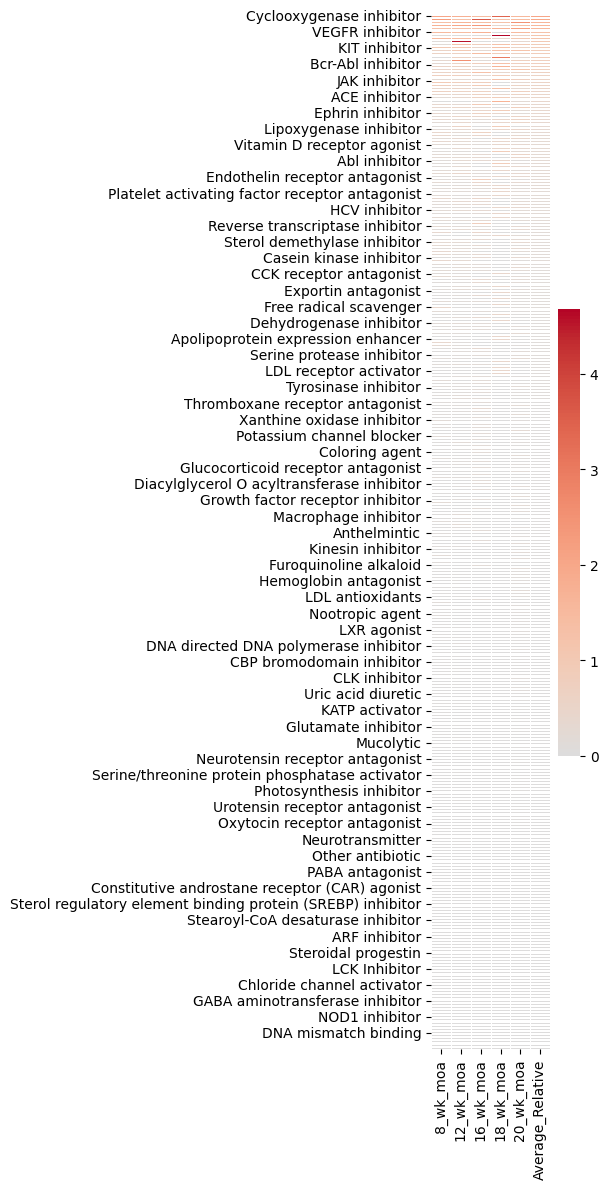

In [7]:

import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_CMAP is your DataFrame and it's already defined
moa_columns = ['8_wk_moa', '12_wk_moa', '16_wk_moa', '18_wk_moa', '20_wk_moa']
moa_frequencies = {}


# Set up the matplotlib figure for relative frequencies heatmap
plt.figure(figsize=(6, 12))

# Draw the heatmap for relative frequencies
sns.heatmap(moa_relative_frequencies_df_sorted, cmap="coolwarm", center=0,
            linewidths=.5, cbar_kws={"shrink": .5})

# Improve the visibility of the labels/cells
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Ensure y labels are horizontal
plt.tight_layout()  # Adjust layout to fit everything

# Show the heatmap for relative frequencies
plt.show()

#Analyse: Frequency of MOAs in each time point 5%


# ANALYSE: Filter and rank

Function to combine top 5% of each timepoint and rank by NCS value. Duplicates are not excluded at this stage

In [40]:
##things to add

#find the 20_wk bug where only -0.69 values come through the timepoint collation even when accepting duplicates.

import pandas as pd

min_20_wk_NCS = df_CMAP['20_wk_NCS'].min()
print(min_20_wk_NCS)

def find_top_compounds(df_CMAP, list_cols, score_cols):
    df_top_compounds = pd.DataFrame()

    # Process each timepoint separately
    for pert_col, score_col in zip(list_cols, score_cols):
        threshold = df_CMAP[score_col].quantile(0.01)  # set percentage here
        # Select rows that meet or exceed the threshold
        df_temp = df_CMAP[df_CMAP[score_col] <= threshold][[pert_col, score_col]].copy()
        df_temp.rename(columns={pert_col: 'pert_iname', score_col: 'NCS'}, inplace=True)  # Standardize column names
        df_temp['Timepoint'] = score_col  # Add a column to indicate the timepoint
        df_top_compounds = pd.concat([df_top_compounds, df_temp], ignore_index=True)

        # Print the number of compounds from each score_col
        print(f"Number of compounds from {score_col} in the top 10%: {df_temp.shape[0]}")

    # Rank based on NCS value, with more negative values receiving higher ranks
    df_top_compounds['Rank'] = df_top_compounds['NCS'].rank(ascending=True)

    # Sort by rank
    df_top_compounds = df_top_compounds.sort_values(by='Rank')

    return df_top_compounds


# Define parameters for the function call
list_cols = [
    '8_wk_pert_iname',
    '12_wk_pert_iname',
    '16_wk_pert_iname',
    '18_wk_pert_iname',
    '20_wk_pert_iname'
]

score_cols = [
    '8_wk_NCS',
    '12_wk_NCS',
    '16_wk_NCS',
    '18_wk_NCS',
    '20_wk_NCS'
]

# Call the function and assign the result to a variable
df_ranked_compounds = find_top_compounds(df_CMAP, list_cols, score_cols)

# Print the top 25 compounds based on NCS value ranks in the top 2%, including duplicates
print("Top 25 compounds based on NCS value ranks in the top 3%, including duplicates:")
print(df_ranked_compounds.head(100))

df_ranked_compounds.to_csv('/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_ranked_compound_CHECKER.csv', index=False, na_rep='NA')



-1.183600144
Number of compounds from 8_wk_NCS in the top 10%: 39
Number of compounds from 12_wk_NCS in the top 10%: 158
Number of compounds from 16_wk_NCS in the top 10%: 6
Number of compounds from 18_wk_NCS in the top 10%: 5
Number of compounds from 20_wk_NCS in the top 10%: 28
Top 25 compounds based on NCS value ranks in the top 3%, including duplicates:
        pert_iname       NCS  Timepoint   Rank
197    BAY-87-2243 -1.942013  16_wk_NCS    1.0
198      estradiol -1.931010  16_wk_NCS    2.0
39      GALR2_GALP -1.919355  12_wk_NCS    3.0
40      entinostat -1.919287  12_wk_NCS    4.0
41     importazole -1.899100  12_wk_NCS    5.0
..             ...       ...        ...    ...
98   helveticoside -1.711810  12_wk_NCS   96.0
30    JNJ-26481585 -1.711659   8_wk_NCS   97.0
31       PNU-74654 -1.709148   8_wk_NCS   98.0
99       bisacodyl -1.708694  12_wk_NCS   99.0
100   methotrexate -1.706619  12_wk_NCS  100.0

[100 rows x 4 columns]


# OPTION: Find drugs of interest across timepoint or group

# ANALYSE: Normalise and merge data frames with MPO

In [41]:
# Make drug names in MPO data lower case
df_MPO['Drug'] = df_MPO['Drug'].str.lower()

# Merge df_ranked_compounds with df_MPO based on the 'pert_iname' column
df_CMAP_MPO = pd.merge(df_ranked_compounds, df_MPO, left_on='pert_iname', right_on='Drug', how='left')

# Drop the duplicate 'Drug' column
df_CMAP_MPO.drop('Drug', axis=1, inplace=True)

df_CMAP_MPO_ranked = df_CMAP_MPO.sort_values(by='Calculated_MPO', ascending=False)
df_CMAP_MPO_ranked['MPO_Rank'] = df_CMAP_MPO_ranked['Calculated_MPO'].rank(ascending=False, method='dense')

total_compounds = len(df_CMAP_MPO_ranked)
compounds_with_mpo = df_CMAP_MPO_ranked['Calculated_MPO'].notna().sum()
compounds_without_mpo = total_compounds - compounds_with_mpo

# Print the results
print("Total number of compounds in the list:", total_compounds)
print("Number of compounds with associated MPO values:", compounds_with_mpo)
print("Number of compounds without associated MPO values:", compounds_without_mpo)

print(df_CMAP_MPO_ranked.dropna().iloc[:50, :6])

df_CMAP_MPO_ranked.to_csv('/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_CMAP_MPO_RESULT.csv', index=False, na_rep='NA')



Total number of compounds in the list: 239
Number of compounds with associated MPO values: 58
Number of compounds without associated MPO values: 181
             pert_iname       NCS  Timepoint   Rank  Calculated_MPO  \
39           ifosfamide -1.771217   8_wk_NCS   40.0        5.750000   
129         ruxolitinib -1.693043  12_wk_NCS  128.0        5.515000   
113           orteronel -1.699679   8_wk_NCS  112.0        5.500000   
81            amonafide -1.723411  12_wk_NCS   81.0        5.490000   
230  diethylcarbamazine -1.069249  20_wk_NCS  231.5        5.339500   
144          cimetidine -1.682848  12_wk_NCS  143.0        5.250000   
55            enalapril -1.752871  12_wk_NCS   55.0        5.184500   
83            guanabenz -1.721552   8_wk_NCS   83.0        5.160000   
61           dinaciclib -1.747140   8_wk_NCS   61.0        5.151619   
100           bisacodyl -1.708694  12_wk_NCS   99.0        5.130000   
38            bisacodyl -1.771856  12_wk_NCS   39.0        5.130000   

#OPTIONAL: Find drugs of interest in final results

In [14]:


# Specify the columns to select from the merged DataFrame
list_cols = ['8_wk_NCS', '12_wk_NCS', '16_wk_NCS', '18_wk_NCS', '20_wk_NCS']
score_cols = ['NCS', 'NCS.1', 'NCS.2', 'NCS.3', 'NCS.4']
compounds_to_find = ['rosiglitazone', 'fluoxetine', 'alisertib', 'tomelukast', 'celastrol', 'pioglitazone', 'TWS-119', 'barasertib', 'clenbuterol', 'withaferin', 'trazodone']

# Filter the DataFrame to only include rows where the 'pert_iname' matches any of the compounds in your list
filtered_df = df_CMAP_MPO_ranked.dropna().loc[df_CMAP_MPO_ranked['pert_iname'].isin(compounds_to_find)]

# Display the filtered DataFrame
print(filtered_df)

        pert_iname       NCS  Timepoint    Rank  Calculated_MPO     ChEMBL ID  \
1512     trazodone -1.209237  12_wk_NCS  1510.0        5.915214     CHEMBL621   
1960  pioglitazone -1.205357  12_wk_NCS  1956.0        5.670000     CHEMBL595   
2200   clenbuterol -0.697608  20_wk_NCS  2222.0        4.435000   CHEMBL49080   
1078    fluoxetine -1.212981  12_wk_NCS  1077.0        3.193000      CHEMBL41   
0        alisertib -1.556027  16_wk_NCS     1.0        2.969000  CHEMBL483158   
2317     alisertib -0.697608  20_wk_NCS  2222.0        2.969000  CHEMBL483158   
2266    barasertib -0.697608  20_wk_NCS  2222.0        1.945000  CHEMBL415049   
713     barasertib -1.216362  12_wk_NCS   712.0        1.945000  CHEMBL415049   
1473    barasertib -1.209548  12_wk_NCS  1471.0        1.945000  CHEMBL415049   

      Phase      mw  logp     TSA  ...  Molecular Species  Molecular Formula  \
1512    4.0  371.87  2.36   45.78  ...            NEUTRAL        C19H22ClN5O   
1960    4.0  356.45  3.16   6

# Display results

In [ ]:
import matplotlib.pyplot as plt

# Assuming compound_info_df is already defined and contains the necessary data
plt.figure(figsize=(10, 6))

# Create a list of colors based on Calculated_MPO values
colors = ['red' if mpo > 4 else 'blue' for mpo in Average_rank_MPO['Calculated_MPO']]

# Scatter plot with specified colors
plt.scatter(Average_rank_MPO['Average_Rank'], Average_rank_MPO['Calculated_MPO'], c=colors)

# Add drug names to specific points
for index, row in Average_rank_MPO.iterrows():
    if row['Calculated_MPO'] > 4 and row['Average_Rank'] < 1000:
        plt.text(row['Average_Rank'], row['Calculated_MPO'], row['Drug'], fontsize=9)

# Invert x-axis to have largest values on the left
plt.gca().invert_xaxis()

# Setting title and labels
plt.title('Average Rank vs Calculated_MPO')
plt.xlabel('Average Rank')
plt.ylabel('Calculated_MPO')
plt.grid(True)
plt.show()

## WHY ARE THEIR RANKS OF 12OOO WHEN THE LARGEST DATA FRAME DOESNT HAVE THIS MANY COMPOUNDS ### 12 WEEKS ACTUALLY HAS 16000 AND IS SKEWING THE DATA

plot volcanos and correlation analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_CMAP = pd.DataFrame(df_CMAP)

# Creating a figure with subplots for each combination of time points
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 8 weeks vs 12 weeks
axs[0].scatter(df_CMAP['NCS_8_weeks'], df_CMAP['NCS_12_weeks'])
axs[0].set_xlabel('NCS at 8 weeks')
axs[0].set_ylabel('NCS at 12 weeks')
axs[0].set_title('8 weeks vs 12 weeks')

# 8 weeks vs 16 weeks
axs[1].scatter(df_CMAP['NCS_8_weeks'], df_CMAP['NCS_16_weeks'])
axs[1].set_xlabel('NCS at 8 weeks')
axs[1].set_ylabel('NCS at 16 weeks')
axs[1].set_title('8 weeks vs 16 weeks')

# 12 weeks vs 16 weeks
axs[2].scatter(df_CMAP['NCS_12_weeks'], df_CMAP['NCS_16_weeks'])
axs[2].set_xlabel('NCS at 12 weeks')
axs[2].set_ylabel('NCS at 16 weeks')
axs[2].set_title('12 weeks vs 16 weeks')

plt.tight_layout()
plt.show()

df_CMAP(head)

#Jacquard Analysis

In [ ]:
# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(series1, series2):
    set1 = set(series1.dropna())
    set2 = set(series2.dropna())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:  # Prevent division by zero
        return np.nan
    return len(intersection) / len(union)



In [ ]:

# Extract columns
col1 = df_CMAP['8 weeks']
col3 = df_CMAP['12 weeks']
col5 = df_CMAP['16 weeks']
col7 = df_CMAP['18 weeks']
col9 = df_CMAP['20 weeks']

# Calculate Jaccard similarities
similarity_8_12 = calculate_jaccard_similarity(col1, col3)
similarity_8_16 = calculate_jaccard_similarity(col1, col5)
similarity_12_16 = calculate_jaccard_similarity(col3, col5)
similarity_8_18 = calculate_jaccard_similarity(col1, col7)
similarity_8_20 = calculate_jaccard_similarity(col1, col9)
similarity_12_18 = calculate_jaccard_similarity(col3, col7)
similarity_12_20 = calculate_jaccard_similarity(col3, col9)
similarity_16_18 = calculate_jaccard_similarity(col5, col7)
similarity_16_20 = calculate_jaccard_similarity(col5, col9)
similarity_18_20 = calculate_jaccard_similarity(col7, col9)

# Print results
print(f"Jaccard Similarity between Week 8 and Week 12: {similarity_8_12}")
print(f"Jaccard Similarity between Week 8 and Week 16: {similarity_8_16}")
print(f"Jaccard Similarity between Week 12 and Week 16: {similarity_12_16}")
print(f"Jaccard Similarity between Week 8 and Week 18: {similarity_8_18}")
print(f"Jaccard Similarity between Week 8 and Week 20: {similarity_8_20}")
print(f"Jaccard Similarity between Week 12 and Week 18: {similarity_12_18}")
print(f"Jaccard Similarity between Week 12 and Week 20: {similarity_12_20}")
print(f"Jaccard Similarity between Week 16 and Week 18: {similarity_16_18}")
print(f"Jaccard Similarity between Week 16 and Week 20: {similarity_16_20}")
print(f"Jaccard Similarity between Week 18 and Week 20: {similarity_18_20}")


Attempt at weighted similarity

In [ ]:
def custom_similarity(df, col_drug1, col_ncs1, col_drug2, col_ncs2):
    # Ensure NCS columns are numeric
    df[col_ncs1] = pd.to_numeric(df[col_ncs1], errors='coerce')
    df[col_ncs2] = pd.to_numeric(df[col_ncs2], errors='coerce')

    # Drop rows where either drug name or NCS is NaN
    df = df.dropna(subset=[col_drug1, col_ncs1, col_drug2, col_ncs2])

    # Creating dictionaries to pair drugs with their NCS values
    drugs_at_time1 = dict(zip(df[col_drug1], df[col_ncs1]))
    drugs_at_time2 = dict(zip(df[col_drug2], df[col_ncs2]))

    # Identifying common and unique drugs
    common_drugs = set(drugs_at_time1.keys()).intersection(set(drugs_at_time2.keys()))
    all_drugs = set(drugs_at_time1.keys()).union(set(drugs_at_time2.keys()))

    # Calculating weighted intersection and union
    intersection = sum(min(drugs_at_time1.get(drug, 0), drugs_at_time2.get(drug, 0)) for drug in all_drugs)
    union = sum(max(drugs_at_time1.get(drug, 0), drugs_at_time2.get(drug, 0)) for drug in all_drugs)

    # Computing similarity
    return intersection / union if union != 0 else 0

# Example usage
similarity_8_12 = custom_similarity(df, '8 weeks', 'NCS', '12 weeks', 'NCS')
similarity_8_16 = custom_similarity(df, '8 weeks', 'NCS', '16 weeks', 'NCS')
similarity_12_16 = custom_similarity(df, '12 weeks', 'NCS', '16 weeks', 'NCS')

print(f"Similarity between Week 8 and Week 12: {similarity_8_12}")
print(f"Similarity between Week 8 and Week 16: {similarity_8_16}")
print(f"Similarity between Week 12 and Week 16: {similarity_12_16}")



Unclear how to interpret these data and also expecting 0-1 range